## **Import libraries**

In [81]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
warnings.filterwarnings("ignore")

### **Load Data**

In [3]:
df=pd.read_csv("insurance.csv")

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## **Data Visualization**

**Unique Values**

In [5]:
{col:list(df[col].unique()) for col in df.select_dtypes("object")}

{'sex': ['female', 'male'],
 'smoker': ['yes', 'no'],
 'region': ['southwest', 'southeast', 'northwest', 'northeast']}

In [6]:


class Pie_plot():

  def __init__(self,serie,title,colors,explode):

    self.serie=serie
    self.title=title
    self.colors=colors
    self.explode=explode

  def pie(self):


    self.serie.plot(kind='pie',title=self.title, figsize=[20,8],
                     colors=self.colors,explode=self.explode,
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*self.serie.sum()))


class Pie_Option(Pie_plot):

  def option_plot(self,option):

    if option== "region":


      super().pie()


    elif option == "smoker":

      super().pie()

      
    elif option == "sex":

      super().pie()
    
    elif option == "children":

      super().pie()

In [7]:
region_serie=df.groupby('region').size()
title="Region Percent"
colors=['#77dd77','#fdfd96','#84b6f4','#fdcae1']
explode= [0,0,0.1,0]

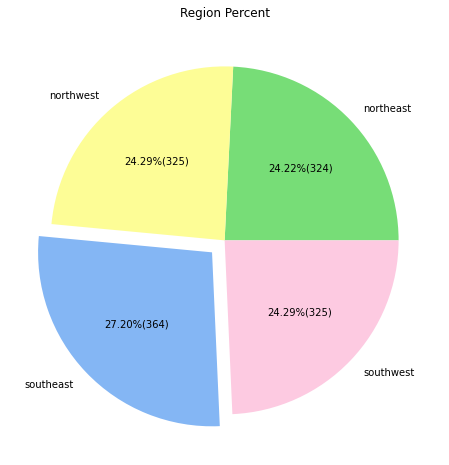

In [8]:
region_pie=Pie_Option(region_serie,title,colors,explode)
region_pie.option_plot("region")

In [9]:
smoker_serie=df.groupby('smoker').size()
title="Smoker Percent"
colors=['#77dd77','#ff6961']
explode=[0.1,0.01]

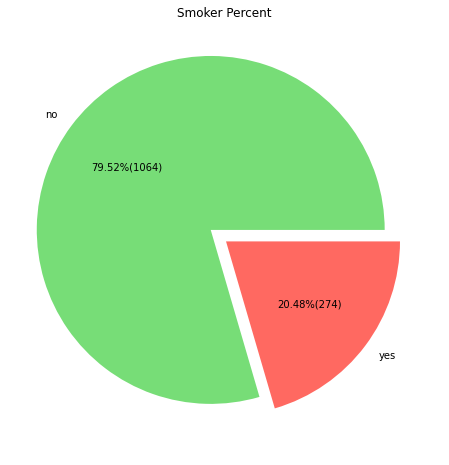

In [10]:
smoker_pie=Pie_Option(smoker_serie,title,colors,explode)
smoker_pie.option_plot("smoker")

In [11]:
sex_serie=df.groupby('sex').size()
title="Sex Percent"
colors=['#FFD1DC','#2271b3']
explode=[0,0]

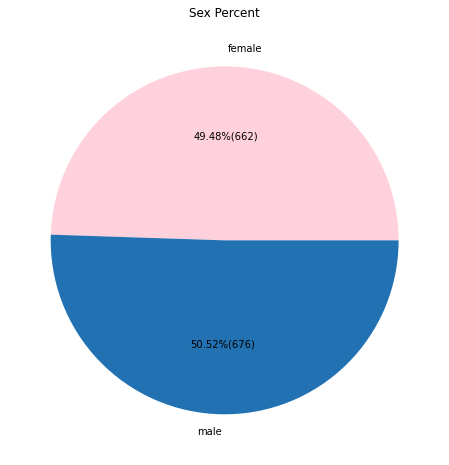

In [12]:
smoker_pie=Pie_Option(sex_serie,title,colors,explode)
smoker_pie.option_plot("sex")

In [13]:
children_serie=df.groupby('children').size()
title='Children Percent'
colors=['#b0f2c2','#fdfd96','#84b6f4','#fdcae1','#b0c2f2','#77dd77']
explode=[0.04,0,0,0,0,0]

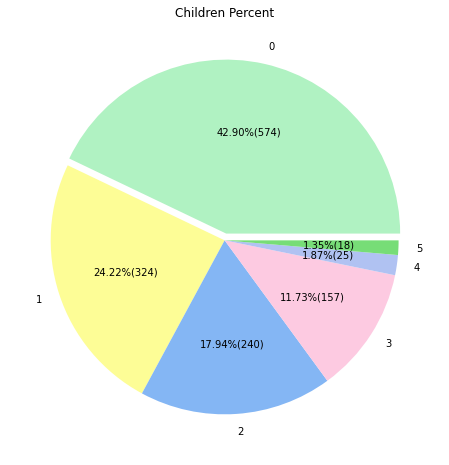

In [14]:
children_pie=Pie_Option(children_serie,title,colors,explode)
children_pie.option_plot("children")

In [15]:
sns.set_style(style="whitegrid")

In [16]:
def histogram(feature,title):


  fig,ax=plt.subplots(1,1,figsize=(20,8))

  ax.set_title(title)
  ax.hist(df[feature],ec="k",color="#FADA5E",lw=3)


  ax.axvline(df[feature].mean(),
           color="red",
           linestyle="--",
           lw=3,label="Mean")


  ax.axvline(df[feature].median(),
           color="blue",
           linestyle="--",
           lw=3,label="Median")

  ax.legend()

  plt.show()

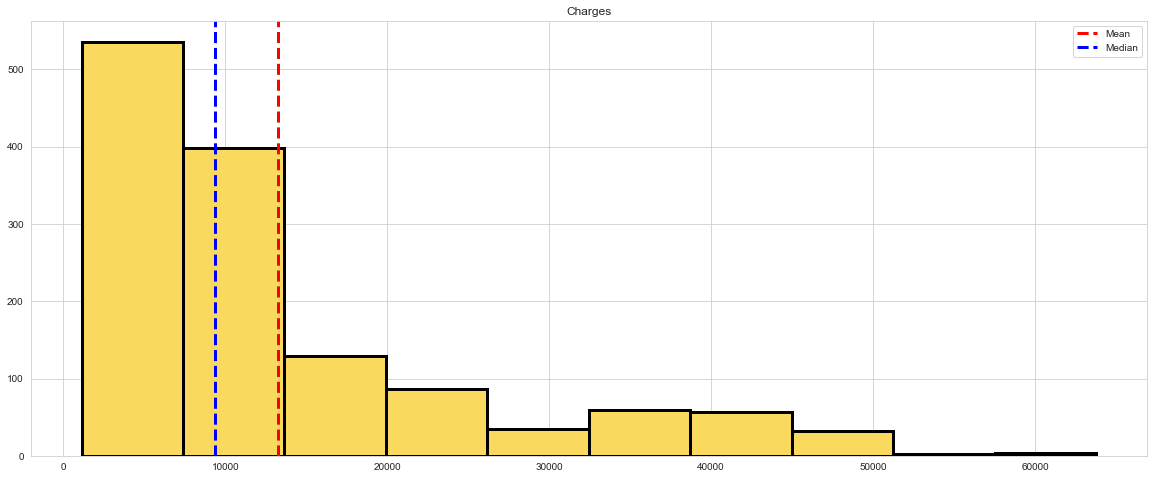

In [17]:
histogram("charges","Charges")

In [18]:
from plotnine import ggplot, aes, geom_point,geom_boxplot,labs,facet_wrap,scale_fill_manual,theme

### **The price of insurance is higher for people who smoke?**

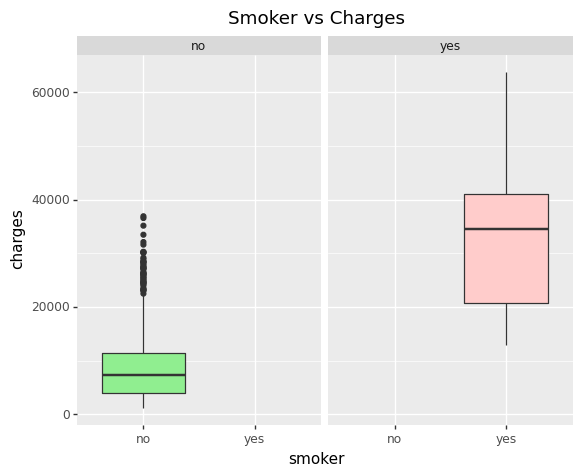

<ggplot: (138000236867)>

In [19]:



(
    
    ggplot(df)  
    + aes(x="smoker",y="charges",fill="smoker")  
    + geom_boxplot() + labs(title="Smoker vs Charges") 
    + facet_wrap("smoker")
    + theme(legend_position="none")
    +  scale_fill_manual(values=["#90ee90","#ffcccb"])
    
  

)



We observe a strong presence of outliers, for the category of non-smokers.

In [20]:
df.groupby("smoker")["charges"].mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

The average price of smokers is considerably much higher than non-smokers. Since smokers generally have a worse state of health and as a consequence the medical charge will be higher.

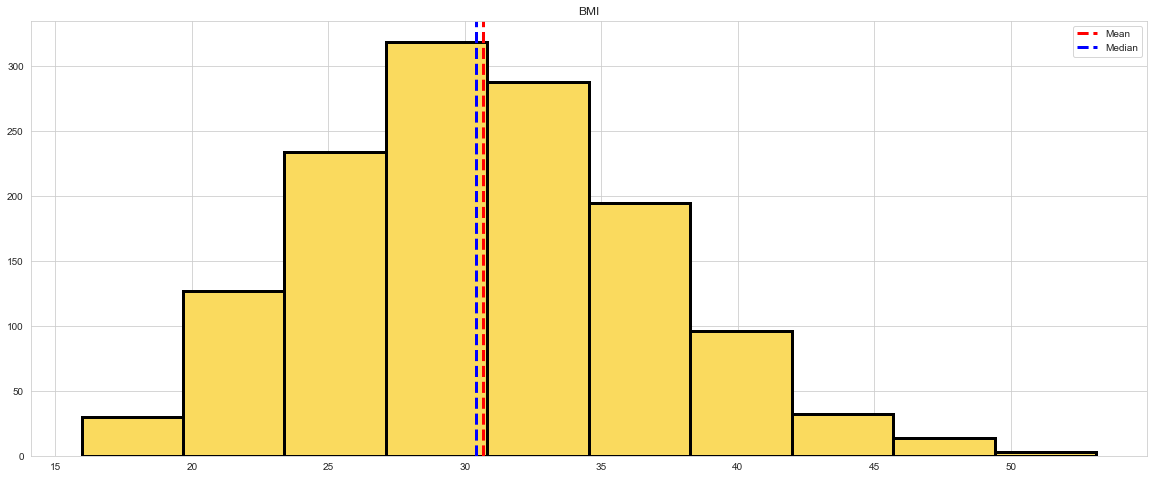

In [21]:
histogram("bmi","BMI")

Most of the BMI data is within a normal distribution. But even so, it is possible to appreciate outlier values ​​in the upper range.

In [22]:
from plotnine.facets import facet_grid

from plotnine.geoms import geom_smooth

def scatter_plots(feature,title):

  return((ggplot(df)  
    + aes(x=feature,y="charges",fill="smoker",alpha=0.1)  
    + geom_point() + labs(title=title,x=feature) 
    + facet_wrap("smoker")
    + theme(legend_position="none")
    +  scale_fill_manual(values=["#90ee90","#ffcccb"])
    + geom_smooth(method="lm")))
  

## **People with a high BMI the insurance charge is higher?**

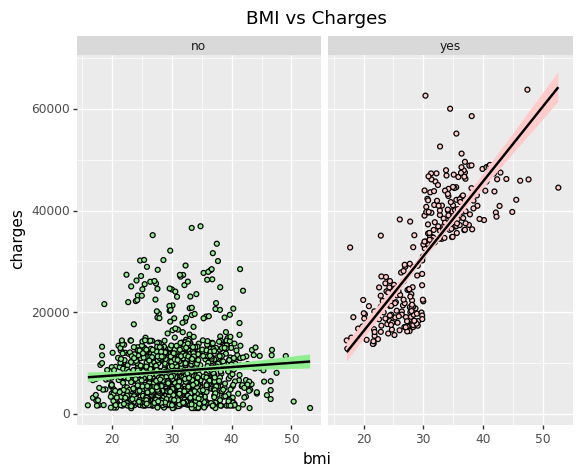

<ggplot: (138000368556)>

In [23]:
scatter_plots("bmi","BMI vs Charges")

* For non-smokers, the data trend remains constant. 
* While for smokers the trend line is linear, 
that is, one value increases proportionally with another.

## **Does age influence the price of insurance?**

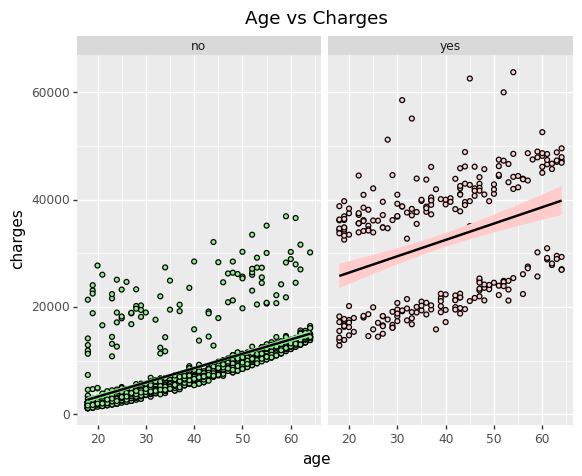

<ggplot: (138000530134)>

In [24]:
scatter_plots("age","Age vs Charges")

We observe 4 "clusters":


*   The first is for healthy people who do not smoke are healthy, as a consequence they do not have severe medical problems.
*   People who do not smoke but have significant health problems.

*  People who smoke but have a good health condition.
*   Users who smoke and have serious medical problems.

It can be simplified under two conditions. The first where the condition is not so serious and the second is when the case is dedicated.

We could create an additional feature, to be able to classify users based on the degree of health of the user. Since, as we can see in the graph, the quality of health influences the medical position.


Using the histogram and the box plot. We confirm the presence of outliers. So we have to give it special processing.

Technically we can give outliers the same treatment as missing values.

* **Delete** those values.
* **Replace** them with a **statistical measure** or by any other value that is in a suitable range.
* **Add** new variables, which we are doing here.

In [25]:
class Intervals():
    
    def __init__(self,feature):
        
        
        self.mean=feature.mean()
        self.sd=feature.std()
        self.interval_range=[1.5,2,2.5,3.0,3.5,4]
        
    def Upper_Interval(self):
        
        for interval in self.interval_range:
            
            upper_interval= self.mean+interval*self.sd
            upper_interval=round(upper_interval,2)
            
            print(f"Interval range {interval}: {upper_interval}")
        
    def Lower_Interval(self):
        
         for interval in self.interval_range:
            
            lower_interval=self.mean-interval*self.sd
            lower_interval=round(lower_interval,2)
            
            print(f"Interval range {interval}: {lower_interval}")
        

We create a class called intervals that have functions that will allow us to make it easier to find the best ideal interval.

In [26]:
class Best_Interval(Intervals):
    
    def __init__(self,feature):
        Intervals.__init__(self,feature)
    
    def Upper_Interval_Ideal(self):
        
        return super().Upper_Interval()
    
    def Lower_Interval_Ideal(self):
        
        return super().Lower_Interval()

In [27]:
bmi_interval_ideal=Best_Interval(df["bmi"])

### **Upper limit BMI**

In [28]:
bmi_interval_ideal.Upper_Interval_Ideal()

Interval range 1.5: 39.81
Interval range 2: 42.86
Interval range 2.5: 45.91
Interval range 3.0: 48.96
Interval range 3.5: 52.01
Interval range 4: 55.06


With an interval of 3 it gives a good value. To be able to replace outliers.
### *Replacing values greater than the upper range*

In [29]:
df["bmi"]=np.where(df["bmi"]>48.95,48.95,df["bmi"])

### **Lower limit BMI**

In [30]:
bmi_interval_ideal.Lower_Interval_Ideal()

Interval range 1.5: 21.52
Interval range 2: 18.47
Interval range 2.5: 15.42
Interval range 3.0: 12.37
Interval range 3.5: 9.32
Interval range 4: 6.27


The appropriate interval value is 2. Since considered with the minimum BMI values ​​regardless of sex is 18.
### *Replacing values greater than the lower range*

In [31]:
df["bmi"]=np.where(df["bmi"]<18,18,df["bmi"])

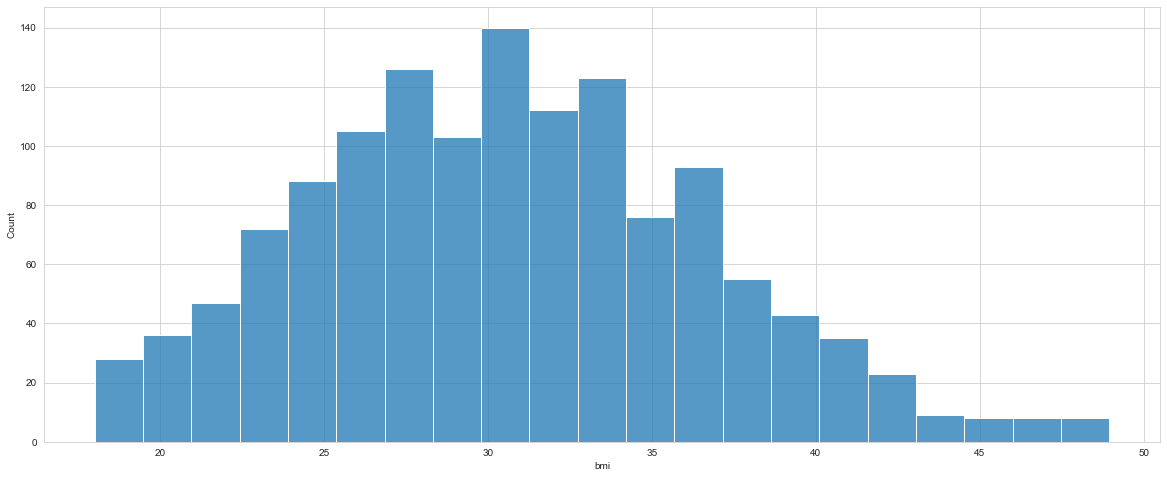

In [32]:
sns.set_style(style="whitegrid")
plt.subplots(1,1,figsize=(20,8))
sns.histplot(data=df,x="bmi")
plt.show()

#### *Separate into smokers and non-smokers*
In order to give a better treatment to the data.

In [33]:
smoker_no_split=df.query("smoker=='no'")
smoker_yes_split=df.query("smoker=='yes'")

### **Smoker no split**

#### **Upper limit Charges**

In [34]:
charges_interval_ideal=Best_Interval(smoker_no_split["charges"])

In [35]:
charges_interval_ideal.Upper_Interval_Ideal()

Interval range 1.5: 17424.94
Interval range 2: 20421.83
Interval range 2.5: 23418.72
Interval range 3.0: 26415.61
Interval range 3.5: 29412.5
Interval range 4: 32409.4


In [36]:
def scatter_plot_age_charges(dataset):
    
    plt.subplots(1,1,figsize=(20,8))
    sns.scatterplot(data=dataset,x="age",y="charges")
    plt.show()
    

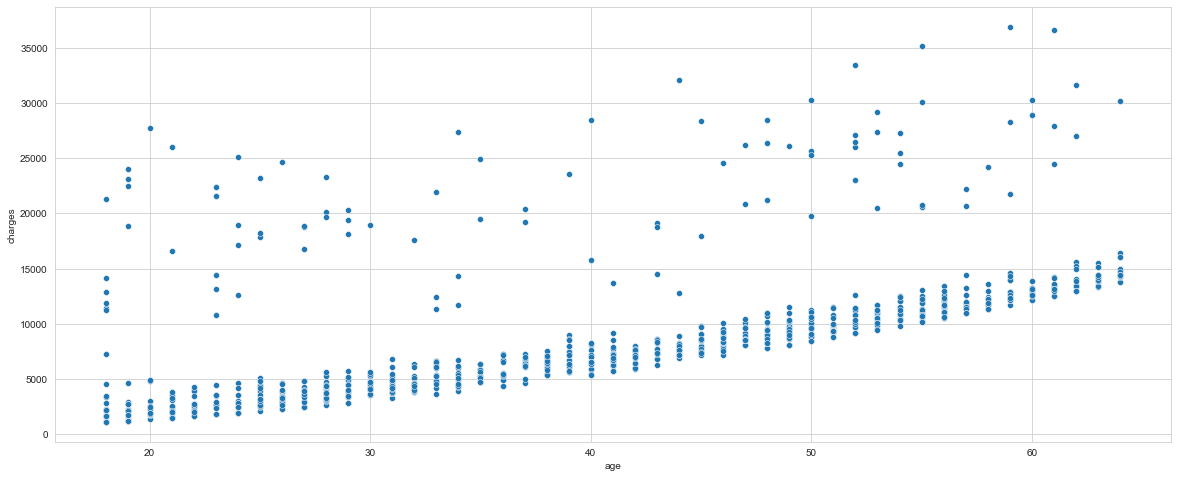

In [37]:
scatter_plot_age_charges(dataset=smoker_no_split)

Using an interval of 1.5 gives good results. We will use the upper interval to group the degree of medical problem if it is severe or not.

#### **Group according to degree of medical problem**

In [38]:
smoker_no_split["medical_problem"]=smoker_no_split["charges"].apply(lambda x: "severe" if x>17000 else "light")

For those values greater than $17,000 US, it will classify them as **severe medical problems.**

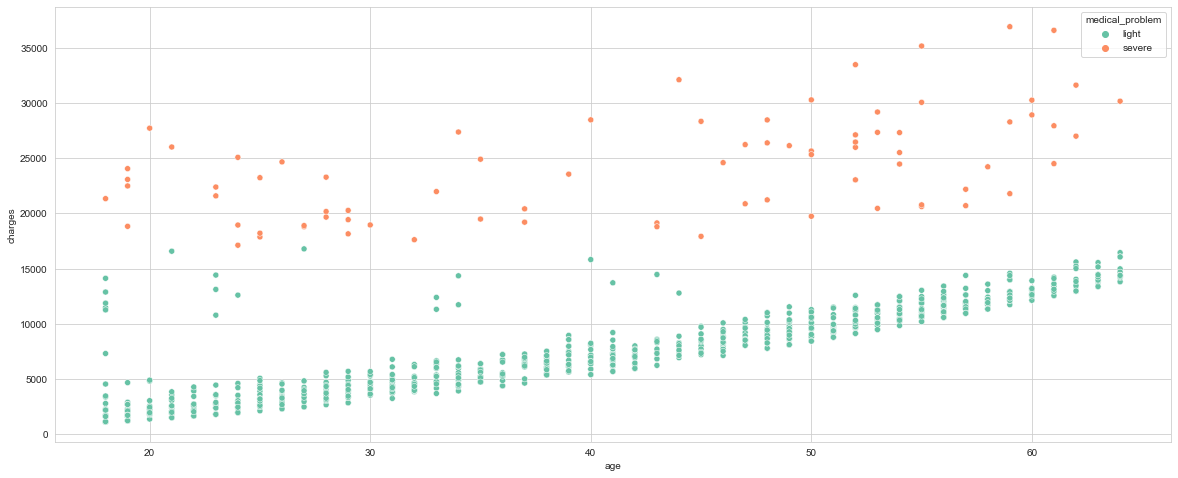

In [39]:
plt.subplots(1,1,figsize=(20,8))
sns.scatterplot(data=smoker_no_split,x="age",y="charges",hue="medical_problem",palette="Set2")
plt.show()

### **Smoker yes split**

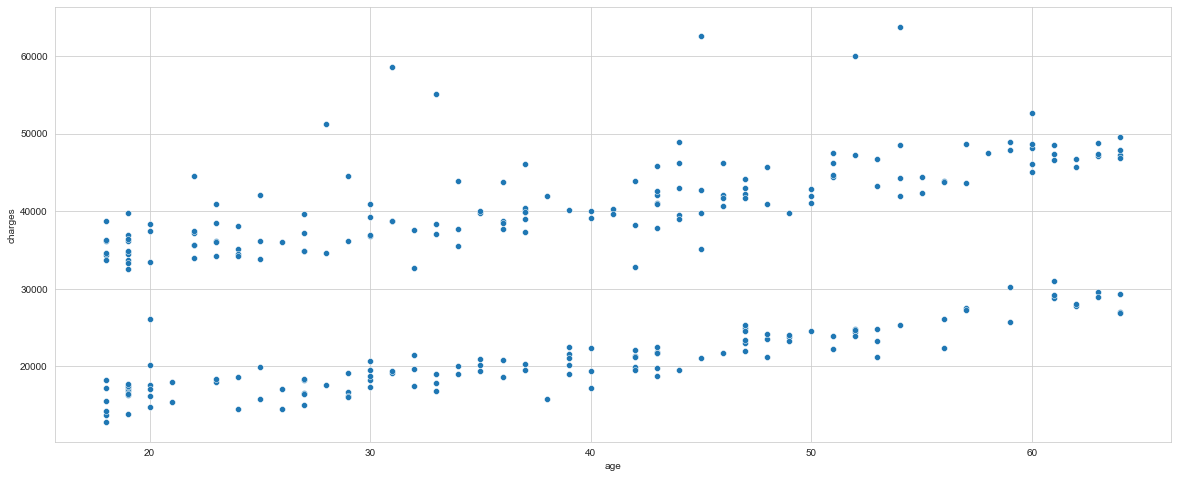

In [40]:
scatter_plot_age_charges(dataset=smoker_yes_split)

From a range higher than $32,000 USD we could create a new group, in a similar way to non-smokers but with a different range

In [41]:
smoker_yes_split["medical_problem"]=smoker_yes_split["charges"].apply(lambda x: "severe" if x > 32000 else "light")

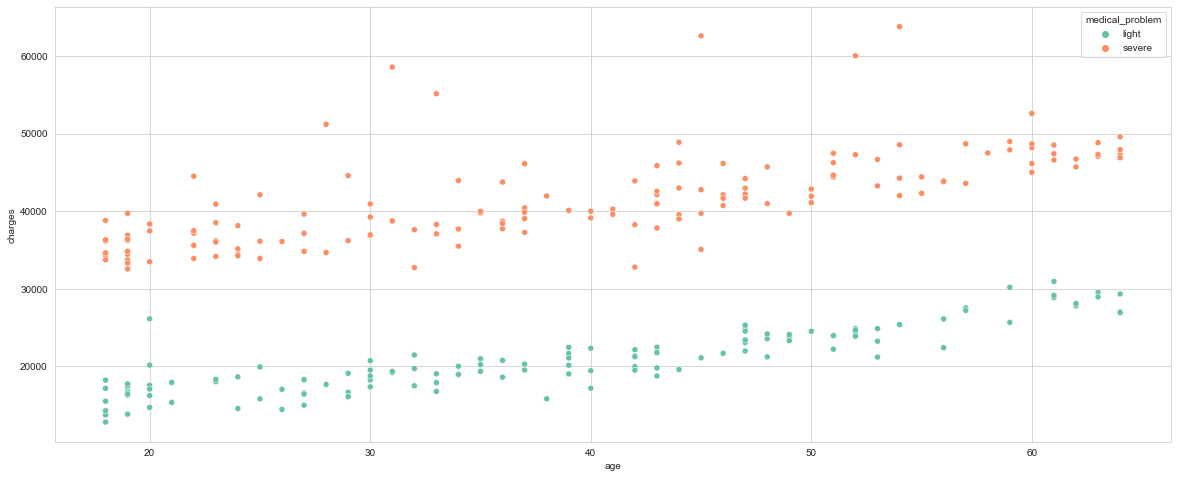

In [42]:
plt.subplots(1,1,figsize=(20,8))
sns.scatterplot(data=smoker_yes_split,x="age",y="charges",hue="medical_problem",palette="Set2")
plt.show()

### **Replace Outliers Values**

In [43]:
smoker_yes_split["charges"]=smoker_yes_split["charges"].apply(lambda x: 48000 if x > 48000 else x)

We replace values greater than $48,000 and substitute them with that amount, since it is the closest value to the outliers.

##### **We create a new dataframe with the clean data**

In [44]:
df_clear=pd.concat([smoker_no_split,smoker_yes_split])

In [45]:
def boxplot():
    

    fig,(ax_box_1,ax_box_2)=plt.subplots(1,2,figsize=(20,8))
    
    ax_box_1.set_title("Adding new feature")

    sns.boxplot(data=df_clear,x="smoker",
            y="charges",
            hue="medical_problem",
            palette="Set2",
            ax=ax_box_1)

    ax_box_2.set_title("Without the new feature")
    sns.boxplot(data=df,
            x="smoker",
            y="charges",
            palette="Set2",
            ax=ax_box_2)
    plt.show()

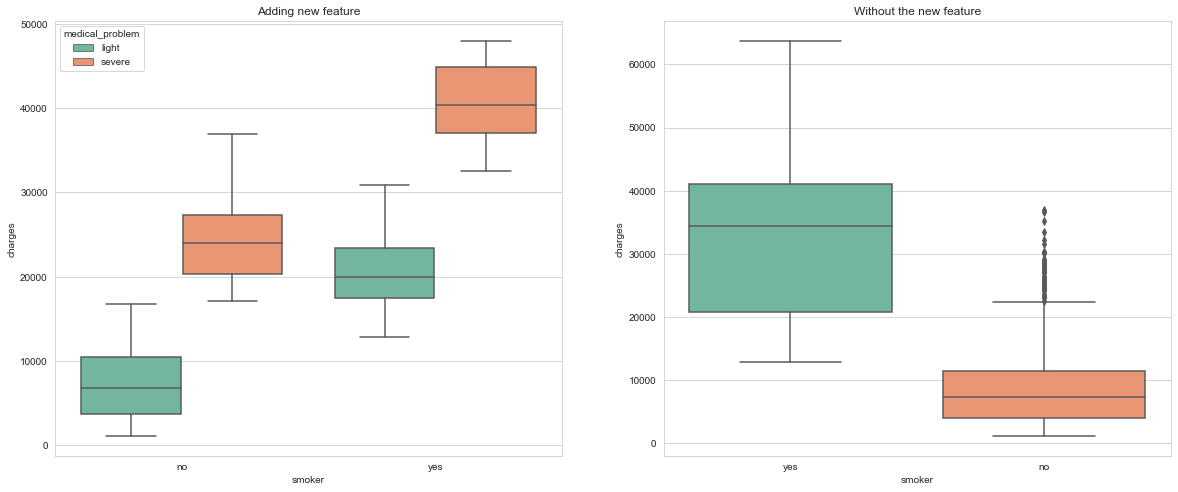

In [46]:
boxplot()

With the new variable we created, we solve the problem of outliers. Thanks to this variable, values that are out of the normal range can be better explained.

#### *We save the dataset with the clean data*

In [48]:
df_clear.to_csv("insurence_clear.csv",index=False)

In [49]:
df=pd.read_csv("insurence_clear.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges,medical_problem
0,18,male,33.770,1,no,southeast,1725.55230,light
1,28,male,33.000,3,no,southeast,4449.46200,light
2,33,male,22.705,0,no,northwest,21984.47061,severe
3,32,male,28.880,0,no,northwest,3866.85520,light
4,31,female,25.740,0,no,southeast,3756.62160,light


###  *Split Inputs and Outputs*

In [50]:
def load_inputs_outputs():
    
    return df.drop(["charges"],axis="columns"),df.charges.values

X,y=load_inputs_outputs()

### *Split data*

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,
                                               test_size=0.33, # 33% for testing
                                               random_state=42)

In [55]:
X_train.shape[0],X_test.shape[0]

(896, 442)

#### *Data preprocessing*

**Note** Decision trees do not require normalization of their inputs; and since XGBoost is essentially an ensemble algorithm comprised of decision trees, it does not require normalization for the inputs either.

We will only perform **One Hot Encoding transformation** for categorical variable.

#### *One Hot Encoding*

<img src="https://miro.medium.com/max/1400/1*ggtP4a5YaRx6l09KQaYOnw.png">

It is used for qualitative categorical variables, for example in the image the color variable.
Where dummy variables are created according to the number of categories of the variables, a 1 is assigned where it complies with the condition and the others are filled with 0.

 Instead of just replacing the labels with random numbers it can affect the performance of the model, for this type of variables. Since we would be giving more weight to the categories that have the highest value. In addition, the One Hot Encoding transformation has the advantage at the geometric level, since there is already the same distance between the categories.

In [56]:
class Preprocessing_OHE():
    
    def __init__(self,X_data):
        self.X_data=X_data
    
    
    def binary(self):
        
        self.X_data["sex"]=self.X_data["sex"].apply(lambda x: 1 if x == "male"  else 0)
        self.X_data["smoker"]=self.X_data["smoker"].apply(lambda x: 1 if x == "yes"  else 0)
        self.X_data["medical_problem"]=self.X_data["medical_problem"].apply(lambda x: 1 if x == "severe"  else 0)
        
        return self.X_data
    
    def multinomial(self):
        
        return pd.get_dummies(self.X_data,columns=["region"])

   ### *Preprocessing Training Data*

In [57]:
X_train_preprocesing=Preprocessing_OHE(X_train)

In [58]:
X_train_ohe=X_train_preprocesing.binary()
X_train_ohe=X_train_preprocesing.multinomial()

In [59]:
X_train_ohe.head()

,age,sex,bmi,children,smoker,medical_problem,region_northeast,region_northwest,region_southeast,region_southwest
1046,18,1,48.950,0,0,0,0,0,1,0
682,55,1,32.775,0,0,0,0,1,0,0
1037,19,0,25.745,1,0,0,0,1,0,0
490,38,0,34.800,2,0,0,0,0,0,1
39,18,0,35.625,0,0,0,1,0,0,0


### *Preprocessing Testing Data*

In [60]:
X_test_preprocesing=Preprocessing_OHE(X_test)

In [61]:
X_test_ohe=X_test_preprocesing.binary()
X_test_ohe=X_test_preprocesing.multinomial()

In [62]:
X_test_ohe.head()

,age,sex,bmi,children,smoker,medical_problem,region_northeast,region_northwest,region_southeast,region_southwest
764,57,1,18.335,0,0,0,1,0,0,0
887,45,1,20.350,3,0,0,0,0,1,0
890,23,1,24.510,0,0,0,1,0,0,0
1293,19,0,32.490,0,1,1,0,1,0,0
259,24,0,27.600,0,0,1,0,0,0,1



<h1><center>XGBOOST</center></h1>

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11276-020-02428-7/MediaObjects/11276_2020_2428_Fig3_HTML.png">

It is part of the assembly algorithms. Which is a type of algorithms that uses weaker models, generally decision trees. The functioning of this model can be summed up with the following phrase: **"Unity is strength".**


Unlike its brother the random forest which is another ensemble algorithm, it will improve each estimator in such a way that each estimator becomes better than the previous one according to the learning rate.


For this particular problem, which is regression, that is, to predict values with a decimal, each estimator performs the prediction to subsequently obtain the average prediction for each estimator.

In [64]:
from xgboost import XGBRegressor

### **Explanation of parameters**

* max_depth: Maximum depth of each decision tree.

* n_estimators: Number of estimators,that is base algorithms.

* learning_rate: Room for improvement for each decision tree, this parameter goes from 0 to 1.

* random_state: For example, if I want to run this algorithm again, it will give me a different result, due to the random state

#### *Creation of Model*

In [65]:
xgb_reg=XGBRegressor(max_depth=3,
                     learning_rate=0.01,
                     n_estimators=596,
                     random_state=42)

#### *Train Model*

In [66]:
xgb_reg.fit(X_train_ohe,Y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=596, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

### *Model Evaluation*

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_squared_error

<h1><center>Mean Square Error</center></h1>

<img src="https://vitalflux.com/wp-content/uploads/2020/09/Regression-terminologies-Page-2-1024x619.png" width=400>

It is the average error between the value predicted by the model with respect to the model.


<h1><center>Cross Validation</center></h1>

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=400>

It consists of subsampling the data according to the number requested by the user. In order to obtain an average of generalization of the data.

In [68]:
class Evaluete():
    
    def __init__(self,X_data,y_true):
            

        self.X_data=X_data
        self.y_true=y_true

        self.model=xgb_reg
        self.predict=self.model.predict(self.X_data)
    
    def mse(self):
        
        return mean_squared_error(self.y_true,self.predict).flatten()

    def r2(self):
        
        return r2_score(self.y_true,self.predict).flatten()

    def cv_score(self):
        
        return cross_val_score(self.model,self.X_data,self.y_true,cv=10).mean().flatten()


### *Train Evaluation*

In [69]:
train_eval=Evaluete(X_train_ohe,Y_train)

In [70]:
mse_train=train_eval.mse()
r2_train=train_eval.r2()
cv_train=train_eval.cv_score()

### *Test Evaluation*

In [71]:
test_eval=Evaluete(X_test_ohe,Y_test)

In [72]:
mse_test=test_eval.mse()
r2_test=test_eval.r2()
cv_test=test_eval.cv_score()

### *Evaluation Dataframe*

In [73]:
features_df={"mse_train":mse_train,
         "mse_test":mse_test,
         "r2_train":r2_train,
         "r2_test":r2_test,
         "cv_train":cv_train,
         "cv_test":cv_test}

In [74]:
df_evaluate=pd.DataFrame(features_df)

In [75]:
df_evaluate

,mse_train,mse_test,r2_train,r2_test,cv_train,cv_test
0,2.351711e+06,3.023848e+06,0.983162,0.979416,0.975549,0.974433


In [82]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test_ohe)

### **Plot Importance**

In [83]:
def plot_importance():
    
    sns.set_style(style="whitegrid")
    shap.summary_plot(shap_values, X_test_ohe, plot_type="bar")
    
    return plt.show()

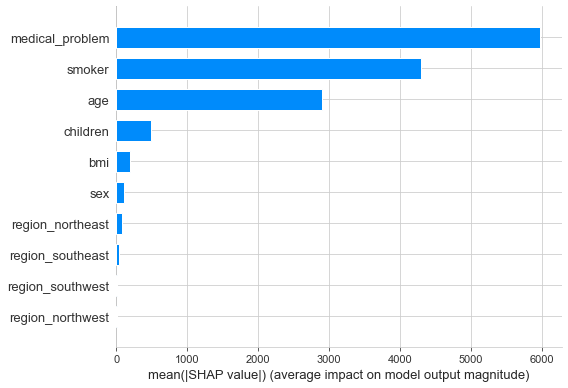

In [86]:
plot_importance()

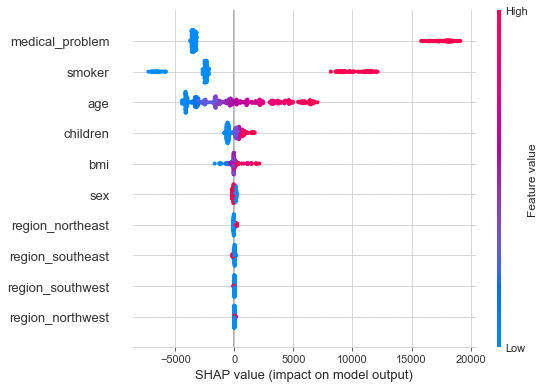

In [87]:
shap.summary_plot(shap_values, X_test_ohe)

* We note that the **medical problem** variable that we created before. It has great weight when estimating the price of the insurance, since if we have a very serious problem, the cost of the insurance will not increase more.

* The **smoker** variable also has great weight, since people generally have a worse state of health.

* The variable **age** adds value to the predictions. Since it can be understood that elderly people require more medical care.

The other variables may not have as much relevance compared to the previous variables that I mentioned earlier. But they can complement the value of the prediction. And that the difference between humans and machines when making predictions is that we rely on only relevant variables, while machines use these variables and also those that are not so significant, since they look for patterns unknown to the naked eye .

#### **We make predictions**

In [88]:
y_pred=xgb_reg.predict(X_test_ohe)
y_pred=y_pred.flatten()

In [89]:
X_test["smoker"]=X_test["smoker"].apply(lambda x: "yes" if x ==1 else "no")

In [90]:
df_test=pd.DataFrame({"y_true":Y_test,
                      "y_pred":y_pred,
                      "smoker":X_test["smoker"]})

In [91]:
def main():
    
    fig,(ax)=plt.subplots(1,1,figsize=(20,8))
    
    ax.set_title("True Values vs Predictions")
    sns.scatterplot(data=df_test,x="y_true",y="y_pred",hue="smoker",palette="Set2")
    sns.lineplot(data=df_test,x="y_true",y="y_true",color="c")

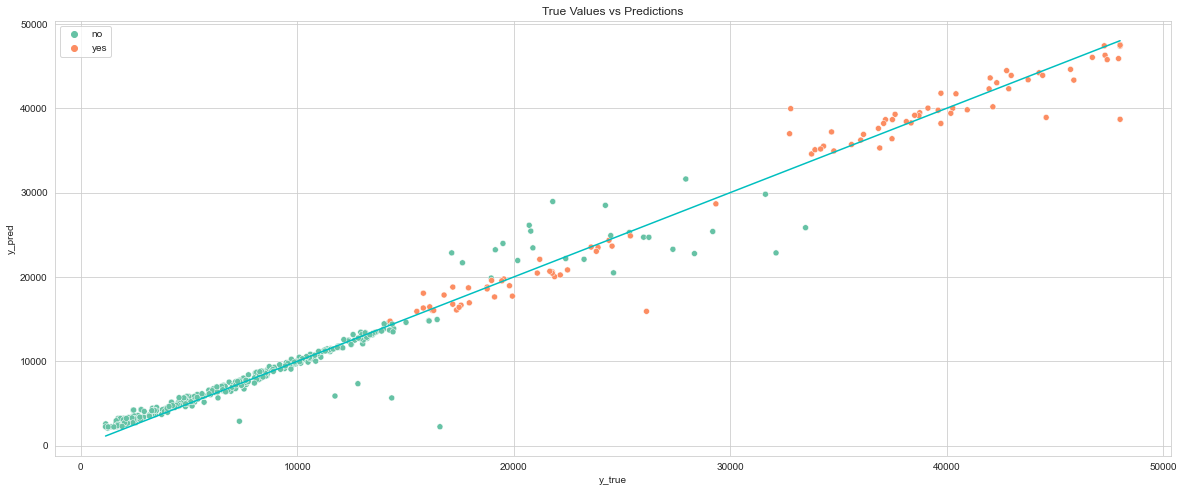

In [92]:
main()

In [104]:
df_test.head()

,y_true,y_pred,smoker
764,11534.87265,11516.696289,no
887,8605.36150,8715.177734,no
890,2396.09590,3481.359863,no
1293,36898.73308,35282.058594,yes
259,18955.22017,19870.119141,no


In [105]:
df_test.query("smoker=='no'").sample(n=20,random_state=42)

,y_true,y_pred,smoker
435,11538.421000,11405.943359,no
629,4350.514400,4753.903320,no
332,7323.734819,2895.726562,no
987,2699.568350,3137.377686,no
744,13470.804400,13154.744141,no
875,4561.188500,5020.006348,no
370,2201.097100,3332.743408,no
282,3180.510100,3602.754883,no
348,7345.084000,7451.192871,no
1055,22395.744240,22174.378906,no


In [106]:
df_test.query("smoker=='yes'").sample(n=20,random_state=42)

,y_true,y_pred,smoker
1302,37465.34375,36379.675781,yes
1127,17179.52200,18797.785156,yes
1235,15817.98570,16316.422852,yes
1128,42856.83800,42300.078125,yes
1293,36898.73308,35282.058594,yes
1122,33750.29180,34576.773438,yes
1242,19798.05455,18954.109375,yes
1283,33907.54800,35073.332031,yes
1228,36021.01120,36221.644531,yes
1078,34303.16720,35501.222656,yes


The algorithm generates quite robust predictions, ***very close to the original value.*** Which this model is apt to solve the problem.

As a curious fact, XGBOOST is one of the most powerful algorithms within Machine Learning, it generate interesting results in such a short time. It is the winner of multiple competitions on the kaggle platform. It has the advantage that we can use a GPU for training, speeding up the training process, something it shares with Deep Learning frameworks.